In [1]:
import os

import numpy as np
from typing import List, Tuple, Any

import seaborn as sns
import matplotlib.pyplot as plt
import torch

import project_path

In [2]:
%load_ext autoreload
%autoreload 2

In [18]:
from attwizard.decoder import get_attention_tensor
from attwizard.decoder import merge_attention_prompt_and_new_tokens
from attwizard.decoder import get_attention_matrix
from attwizard.decoder import condense_attention
from attwizard.decoder import heatmap_visualize

import torch


In [3]:
MODEL_FOLDER = "../huggingface_models/gpt-neo"
FOLDER_WITH_SAMPLES = "code_snippet_samples"

In [5]:
from transformers import AutoTokenizer, GPTNeoForCausalLM

if os.path.exists(os.path.join(MODEL_FOLDER, "pytorch_model.bin")):
    print("Model loaded locally...")
    
    tokenizer = AutoTokenizer.from_pretrained(MODEL_FOLDER)
    model = GPTNeoForCausalLM.from_pretrained(MODEL_FOLDER)
else:
    print("Model downloaded...")
    
    tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
    model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-125M")
    
    tokenizer.save_pretrained("../huggingface_models/gpt-neo")
    model.save_pretrained("../huggingface_models/gpt-neo")
print(model)

Model loaded locally...
GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0, inplace=False)
            (resid_dropout): Dropout(p=0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Li

In [6]:
prompt = open(os.path.join(FOLDER_WITH_SAMPLES, "example.py"), 'r').read()

## Prediction A

In [9]:
input_ids = tokenizer(prompt, return_tensors="pt").input_ids
torch.manual_seed(42)

model_output_A = model.generate(
    input_ids,
    do_sample=True,
    #temperature=0.0000001,
    temperature=0.8,
    output_attentions=True,
    max_length=100, 
    return_dict_in_generate=True
)
att_tensor_A = get_attention_tensor(
    model_output=model_output_A
)
generated_text_A = tokenizer.decode(model_output_A["sequences"][0])
print(generated_text_A)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


def sum(a, b):
    c = a
    d = b
    e = c + d
    return e

# Q: what is the result of print(sum(1, 2))
# A: 1
# B: 2

def print(x):
    print(x.replace(" "," ", "")).replace(" "," ", "")
    print(


CASE A: This view aggreagets all the layers and heads with a max function


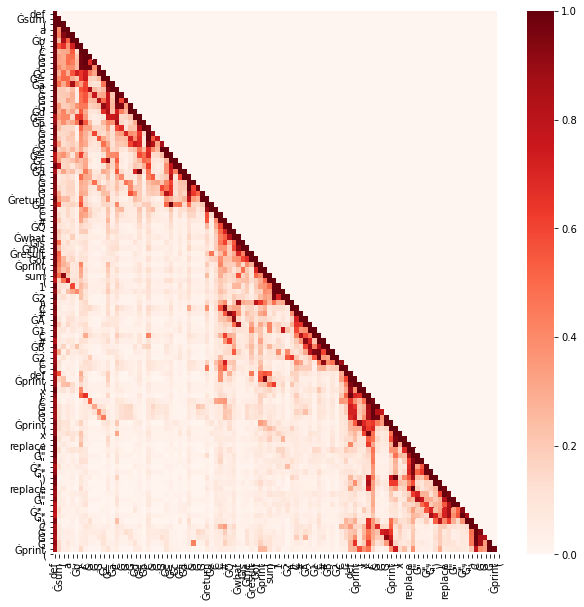

In [20]:
condensed_att_tensor = \
    merge_attention_prompt_and_new_tokens(att_tensor_A)
condensed_att_tensor = \
    condense_attention(
        condensed_att_tensor, 
        reduce_direction="both",
        reduce_function=torch.amax)
att_matrix = get_attention_matrix(
    attention_tensor=condensed_att_tensor)
heatmap_visualize(
    attention_matrix=att_matrix,
    token_names=tokenizer.convert_ids_to_tokens(model_output_A["sequences"][0])
)
print("CASE A: This view aggreagets all the layers and heads with a max function")

## Prediction B

In [10]:
input_ids = tokenizer(prompt, return_tensors="pt").input_ids
torch.manual_seed(37)

model_output_B = model.generate(
    input_ids,
    do_sample=True,
    #temperature=0.0000001,
    temperature=0.8,
    output_attentions=True,
    max_length=100, 
    return_dict_in_generate=True
)
att_tensor_B = get_attention_tensor(
    model_output=model_output_B
)
generated_text_B = tokenizer.decode(model_output_B["sequences"][0])
print(generated_text_B)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


def sum(a, b):
    c = a
    d = b
    e = c + d
    return e

# Q: what is the result of print(sum(1, 2))
# A: (1, 3, 2)
# B: (3, 4, 2)
# C: (2, 1, 3)
# D: (2, 1, 3)
#


CASE A: This view aggreagets all the layers and heads with a max function


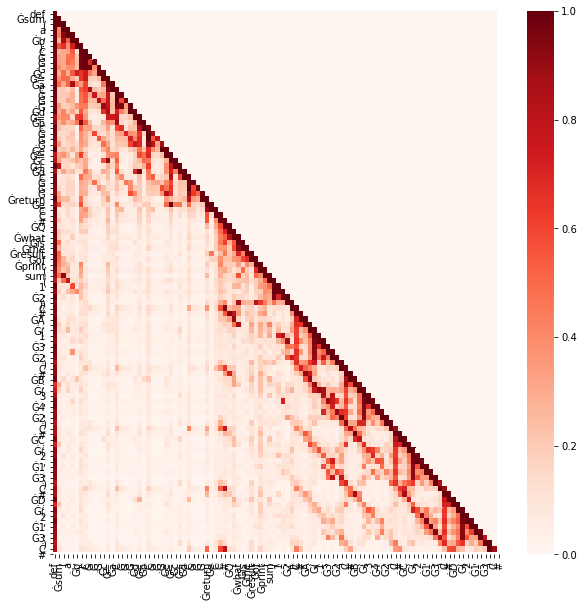

In [21]:
condensed_att_tensor = \
    merge_attention_prompt_and_new_tokens(att_tensor_B)
condensed_att_tensor = \
    condense_attention(
        condensed_att_tensor, 
        reduce_direction="both",
        reduce_function=torch.amax)
att_matrix = get_attention_matrix(
    attention_tensor=condensed_att_tensor)
heatmap_visualize(
    attention_matrix=att_matrix,
    token_names=tokenizer.convert_ids_to_tokens(model_output_B["sequences"][0])
)
print("CASE A: This view aggreagets all the layers and heads with a max function")

## Check if they have the same attention tensor

In [31]:
total_non_zero_elements = sum([
    int(torch.count_nonzero(head).numpy()) 
    for layer in model_output_A["attentions"]
    for head in layer
])
total_non_zero_elements

710022

In [11]:
att_tensor_A == att_tensor_B

tensor([[[[[[ True,  True,  True,  ...,  True,  True,  True],
            [ True,  True,  True,  ...,  True,  True,  True],
            [ True,  True,  True,  ...,  True,  True,  True],
            ...,
            [ True,  True,  True,  ...,  True,  True,  True],
            [ True,  True,  True,  ...,  True,  True,  True],
            [ True,  True,  True,  ...,  True,  True,  True]],

           [[ True,  True,  True,  ...,  True,  True,  True],
            [ True,  True,  True,  ...,  True,  True,  True],
            [ True,  True,  True,  ...,  True,  True,  True],
            ...,
            [ True,  True,  True,  ...,  True,  True,  True],
            [ True,  True,  True,  ...,  True,  True,  True],
            [ True,  True,  True,  ...,  True,  True,  True]],

           [[ True,  True,  True,  ...,  True,  True,  True],
            [ True,  True,  True,  ...,  True,  True,  True],
            [ True,  True,  True,  ...,  True,  True,  True],
            ...,
            [ T

In [13]:
diff_tensor = att_tensor_A - att_tensor_B
n_different_elems = int(torch.count_nonzero(diff_tensor).numpy())
n_different_elems

464324

In [34]:
perc_diff_elems = n_different_elems/total_non_zero_elements * 100
print(f"There are {perc_diff_elems:.2f}% different elements")

There are 65.40% different elements
